### 1. Описание набора данных

Набор данных ```California Housing Prices``` содержит сведения о домах в штате Калифорния, основанных на данных переписи населения данного шатата 1990 года. Целевой переменной является медианная стоимость дома - ```median_house_value```.

Описание колонок:

- ```longitude``` -  долгота
- ```latitude``` - широта
- ```housing_median_age``` - Средний возраст жилья
- ```total_rooms``` - Общее количество комнат
- ```total_bedrooms``` - Общее количество спален
- ```population``` - Население
- ```households``` - домохозяйства  
- ```median_income``` - Средний доход
- ```median_house_value``` - Средняя стоимость жилья  
- ```ocean_proximity``` - Близость к океану   

### 2. Импорт библиотек

In [2]:
import dtreeviz
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib.request
import warnings

from scipy.stats import yeojohnson
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

In [3]:
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib').setLevel(logging.ERROR)

### 3. Определение функций

In [4]:
def calculate_metric(model_pipe, X, y, metric=r2_score):
  """Расчет метрики.
  Параметры:
  ===========
  model_pipe: модель или pipeline
  X: признаки
  y: истинные значения
  metric: метрика (r2 - по умолчанию)
  """
  y_model = model_pipe.predict(X)
  return metric(y, y_model)

In [5]:
def feature_importance_plotter(model, features_names):
  """Отрисовка значимости признаков в виде горизонтальных столбчатых диаграмм.
  Параметры:
  ===========
  model: модель
  features_names: список имен признаков
  """
  feature_importance = model.feature_importances_
  sorted = np.argsort(feature_importance)
  ypos = np.arange(len(features_names))
  fig = plt.figure(figsize=(8,4))
  plt.barh(ypos, feature_importance[sorted])
  plt.xlim([0,1])
  plt.ylabel('Параметры')
  plt.xlabel('Значимость')
  plt.yticks(ypos,features_names[sorted] );

In [6]:
def cross_validation (X, y, model, scoring, cv_rule):
  """Расчет метрик на кросс-валидации.
  Параметры:
  ===========
  model: модель или pipeline
  X: признаки
  y: истинные значения
  scoring: словарь метрик
  cv_rule: правило кросс-валидации
  """
  scores = cross_validate(model, X, y, scoring=scoring, cv=cv_rule)
  print('Ошибка на кросс-валидации')
  DF_score = pd.DataFrame(scores)
  display(DF_score)
  print('\n')
  print(DF_score.mean()[2:])

### 4. Создание каталога и скачивание данных

In [7]:
if not os.path.exists('data'):
  os.makedirs('data')

urllib.request.urlretrieve('https://raw.githubusercontent.com/Losyash/mbml_II_hw/refs/heads/main/lab1/data/housing.csv', 'data/housing.csv')

('data/housing.csv', <http.client.HTTPMessage at 0x20e8dc68980>)

### 5. Загрузка набора данных из файла

In [8]:
df = pd.read_csv('data/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 5. Предварительный анализ и обработка данных

#### 5.1. Получение сведений о количестве записей и типах столбцов

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#### 5.2. Получение сведений о пропущенных значениях

In [10]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

#### 5.3. Удаление строк с пропущенными значениями

In [11]:
# Удалztv все строки в которых есть пропущенное значение в столбце total_bedrooms

df = df.dropna(subset=['total_bedrooms'])
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

#### 5.4. Формирование списков категориальных и числовых столбцов

In [12]:
categorical_columns = []
numeric_columns = []

for column_name in df.columns:
  if (df[column_name].dtypes == object): categorical_columns += [column_name] 
  else: numeric_columns += [column_name]

print(f'Категориальные столбцы {categorical_columns}', f'Числовые стообцы{numeric_columns}', sep='\n')

Категориальные столбцы ['ocean_proximity']
Числовые стообцы['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']


#### 5.5. Построегие гистограмм столбцов с числовыми данными

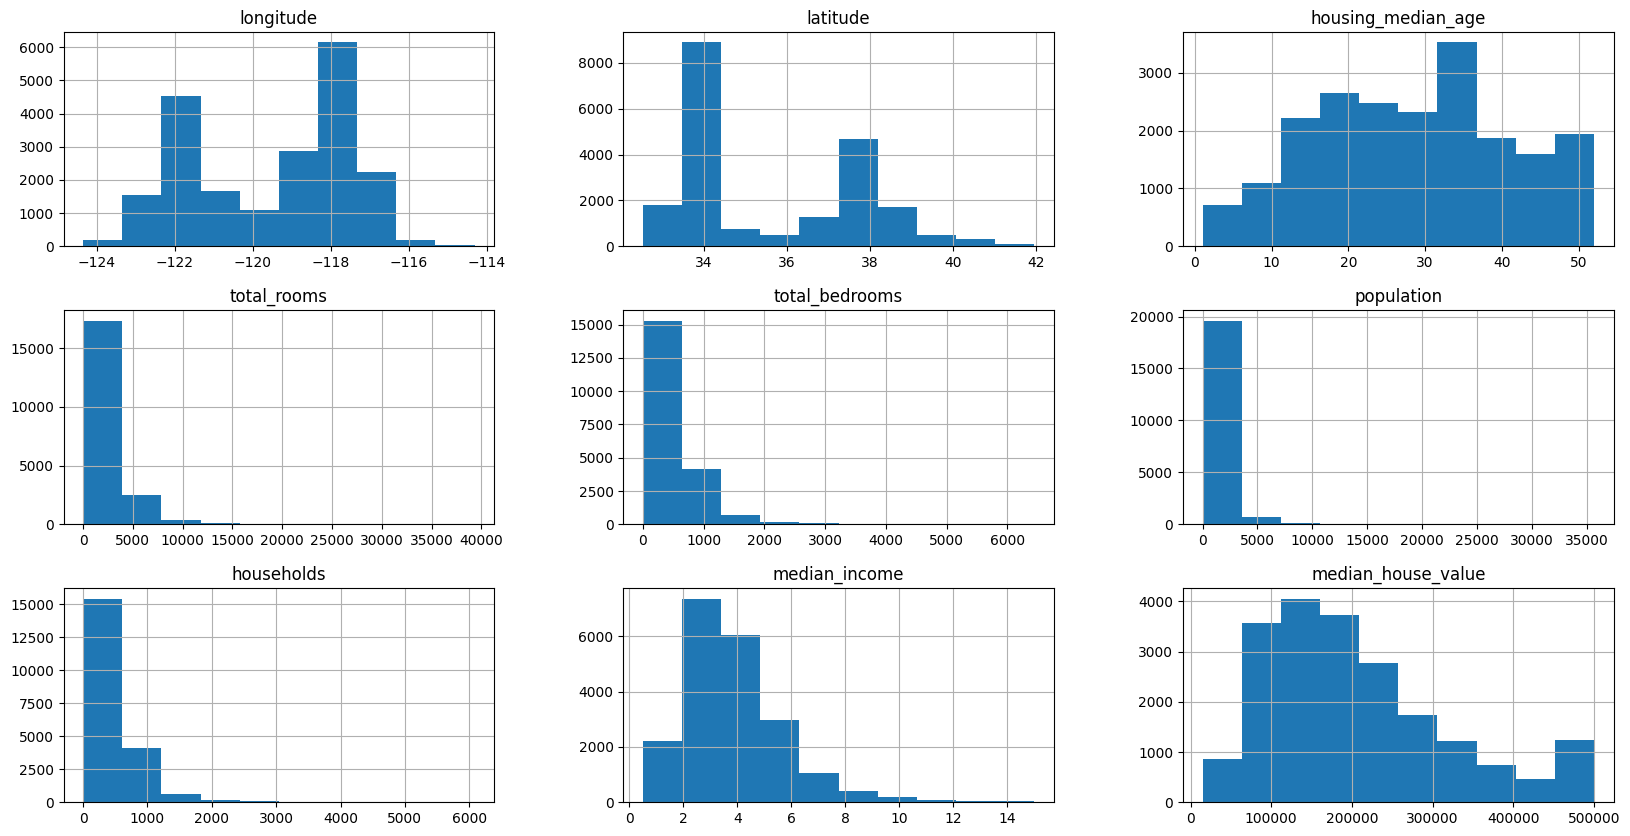

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
df.hist(column=numeric_columns, ax=axs);

In [14]:
for column in numeric_columns[3:]:
  df[column], _ = yeojohnson(df[column])

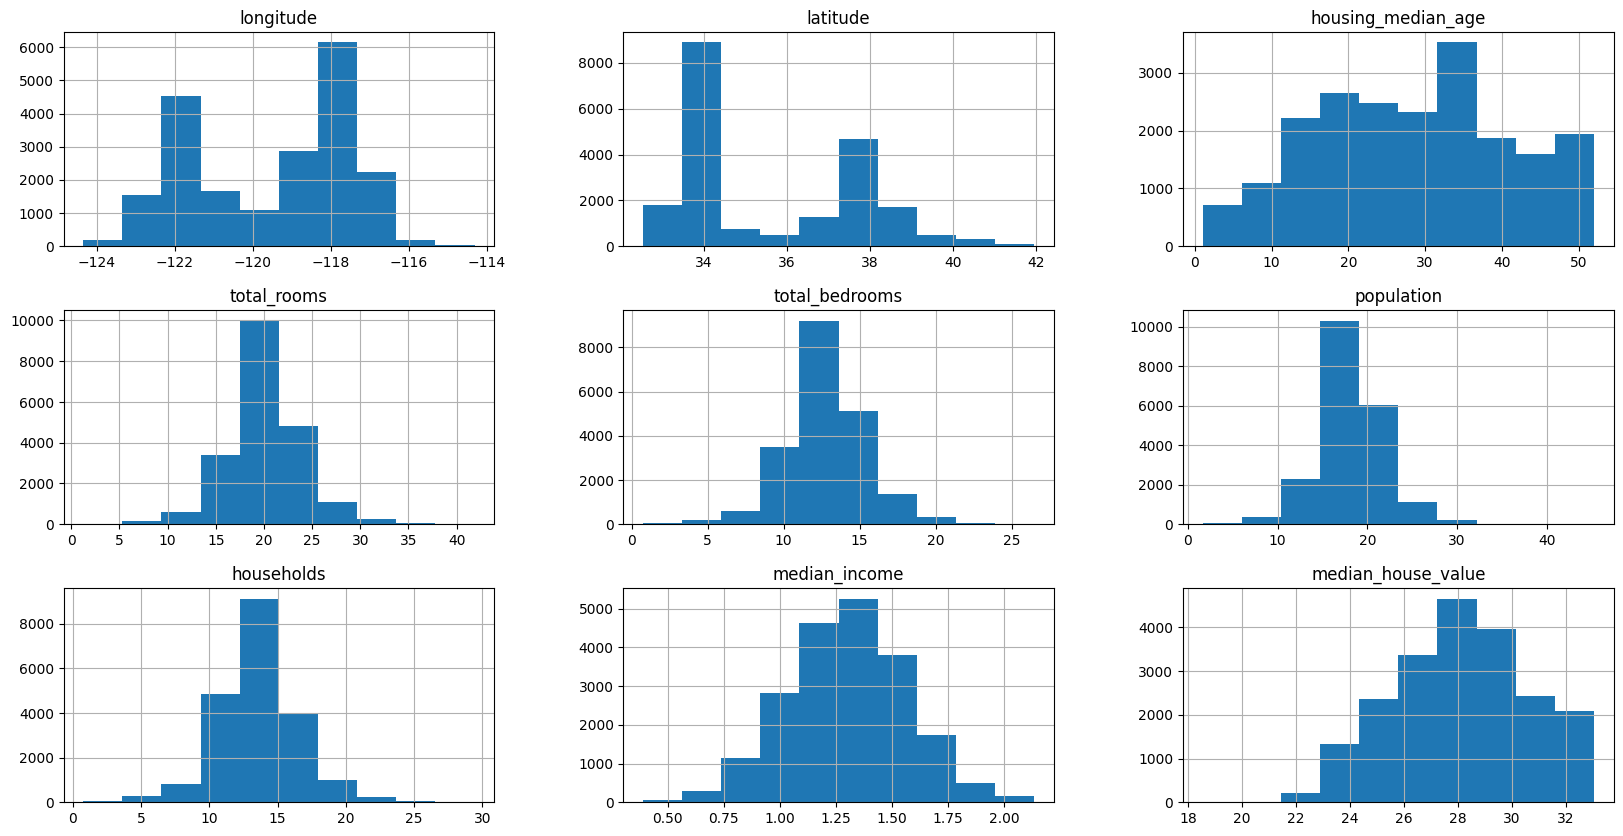

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
df.hist(column=numeric_columns, ax=axs);

### 6. Пайплайны преобразования данных

#### 6.1. Описание классов преобразования данных

In [16]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
  def __init__(self, threshold=0.05):
    self.threshold = threshold
    self.quantiles = {}

  def fit(self, X, y=None):
    for col in X.select_dtypes(include='number'):
      low_quantile = X[col].quantile(self.threshold)
      high_quantile = X[col].quantile(1 - self.threshold)
      self.quantiles[col] = (low_quantile, high_quantile)
    return self

  def transform(self, X):
    X_copy = X.copy()
    for col in X.select_dtypes(include='number'):
      low_quantile, high_quantile = self.quantiles[col]
      rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
      if rare_mask.any():
        rare_values = X_copy.loc[rare_mask, col]
        replace_value = np.mean([low_quantile, high_quantile])
        if rare_values.mean() > replace_value:
          X_copy.loc[rare_mask, col] = high_quantile
        else:
          X_copy.loc[rare_mask, col] = low_quantile
    return X_copy

In [17]:
class RareGrouper(BaseEstimator, TransformerMixin):
  def __init__(self, threshold=0.05, other_value='Other'):
    self.threshold = threshold
    self.other_value = other_value
    self.freq_dict = {}

  def fit(self, X, y=None):
    for col in X.select_dtypes(include=['object']):
      freq = X[col].value_counts(normalize=True)
      self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
    return self

  def transform(self, X, y=None):
    X_copy = X.copy()
    for col in X.select_dtypes(include=['object']):
      X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
    return X_copy

In [18]:
class TargetEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, cols=None):
    self.cols = cols
    self.target_mean = {}

  def fit(self, X, y):
    if self.cols is None:
      self.cols = X.columns
    for col in self.cols:
      self.target_mean[col] = {}
      X_copy = X.copy()
      X_copy[y.name]=y
      self.target_mean[col] = X_copy.groupby(col)[y.name].mean().to_dict()
    return self

  def transform(self, X):
    for col in self.cols:
      X[col] = X[col].map(self.target_mean[col])
      X[col] = X[col].fillna(np.mean(X[col]))
    return X

#### 6.2. Создание пайплайнов

In [19]:
numeric_longitude = ['longitude']
numeric_longitude_pipeline = Pipeline([
  ('QuantReplace', QuantileReplacer(threshold=0.01)),
  ('scaler', None)
])

numeric_latitude = ['latitude']
numeric_latitude_pipeline = Pipeline([
  ('scaler', None)
])

numeric_housing_median_age = ['housing_median_age']
numeric_housing_median_age_pipeline = Pipeline([
  ('QuantReplace', QuantileReplacer(threshold=0.01)),
  ('power', None)
])

numeric_total_rooms = ['total_rooms']
numeric_total_rooms_pipeline = Pipeline([
  ('scaler', None)
])

numeric_total_bedrooms = ['total_bedrooms']
numeric_total_bedrooms_pipeline = Pipeline([
  ('scaler', None)
])

numeric_population = ['population']
numeric_population_pipeline = Pipeline([
    ('scaler', None)
])

numeric_households = ['households']
numeric_households_pipeline = Pipeline([
  ('scaler', None)
])

numeric_median_income = ['median_income']
numeric_median_income_pipeline = Pipeline([
    ('scaler', None)
])

categorical_ocean_proximity = ['ocean_proximity']
categorical_ocean_proximity_pipeline = Pipeline([
  ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
  ('encoder', TargetEncoder())
])

### 8. Разделение данных на тренировачные и тестовые

In [20]:
X, y = df.drop(columns = ['median_house_value']), df['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 9. Использование деревьев решений для задачи регрессии на числовых данных

#### 9.1. Создание пайплайна для числовых признаков

In [21]:
numeric_preprocessors = ColumnTransformer(transformers=[
  ('num_longitude', numeric_longitude_pipeline, numeric_longitude),
  ('num_latitude', numeric_latitude_pipeline, numeric_latitude),
  ('num_housing_median_age', numeric_housing_median_age_pipeline, numeric_housing_median_age),
  ('num_total_rooms', numeric_total_rooms_pipeline, numeric_total_rooms),
  ('num_total_bedrooms', numeric_total_bedrooms_pipeline, numeric_total_bedrooms),
  ('num_population', numeric_population_pipeline, numeric_population),
  ('num_households', numeric_households_pipeline, numeric_households),
  ('num_median_income', numeric_median_income_pipeline, numeric_median_income)
])

#### 9.2. Объединение названия числовых колонок в один список

In [22]:
numeric_columns_list = np.hstack([
  numeric_longitude,
  numeric_latitude,
  numeric_housing_median_age,
  numeric_total_rooms,
  numeric_total_bedrooms,
  numeric_population,
  numeric_households,
  numeric_median_income
])

#### 9.3. Преобразование данных

In [23]:
X_train_preprocessed = numeric_preprocessors.fit_transform(X_train)
X_test_preprocessed = numeric_preprocessors.transform(X_test)

### 9.4. Обучение модели

In [24]:
numeric_model = DecisionTreeRegressor(max_leaf_nodes=40, min_samples_split=5, criterion='absolute_error')
numeric_model.fit(X_train_preprocessed, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_leaf_nodes=40,
                      min_samples_split=5)

##### 9.5. Вывод значимости признаков

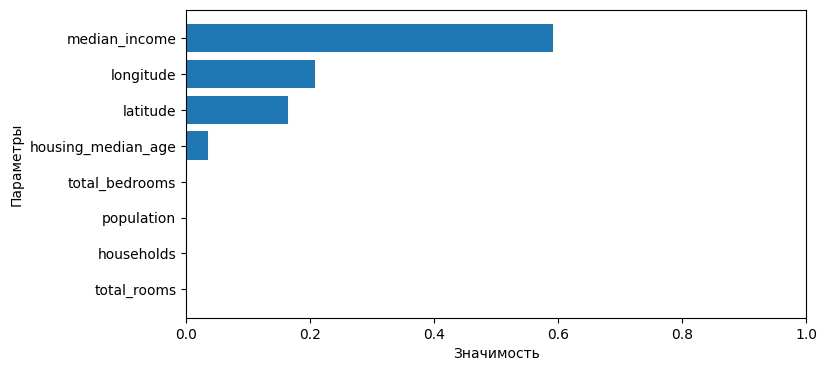

In [25]:
feature_importance_plotter(numeric_model, numeric_columns_list)

#### 9.6. Оценка метрик

In [26]:
print(
  f'R2 на тренировочной выборке: {calculate_metric(numeric_model, X_train_preprocessed, y_train)}',
  f'R2 на тестовой выборке: {calculate_metric(numeric_model, X_test_preprocessed, y_test)}',
  f'MSE на тренировочной выборке: {calculate_metric(numeric_model, X_train_preprocessed, y_train, mse)}',
  f'MSE на тестовой выборке: {calculate_metric(numeric_model, X_test_preprocessed, y_test, mse)}',
  sep='\n'
)

R2 на тренировочной выборке: 0.6937052230216261
R2 на тестовой выборке: 0.6768196306283829
MSE на тренировочной выборке: 1.9798258698909712
MSE на тестовой выборке: 2.1179635263547807


#### 9.7. Кросс-валидация

In [27]:
scoring = {
  'R2': 'r2',
  '-MSE': 'neg_mean_squared_error',
  '-MAE': 'neg_mean_absolute_error',
  '-Max': 'max_error'
}

cross_validation (
  X_train_preprocessed,
  y_train,
  numeric_model,
  scoring,
  ShuffleSplit(n_splits=5, random_state=42)
)

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,3.559778,0.003001,0.679044,-2.000191,-1.046443,-7.474033
1,3.328767,0.002000,0.656762,-2.219487,-1.095721,-7.427217
2,3.551224,0.002999,0.685355,-2.040256,-1.063993,-7.314141
3,3.413358,0.002748,0.639928,-2.261513,-1.109253,-8.022788
4,3.329070,0.002000,0.672045,-2.098766,-1.052364,-12.476208




test_R2      0.666627
test_-MSE   -2.124043
test_-MAE   -1.073555
test_-Max   -8.542877
dtype: float64


#### 9.8. Визуализация ошибок

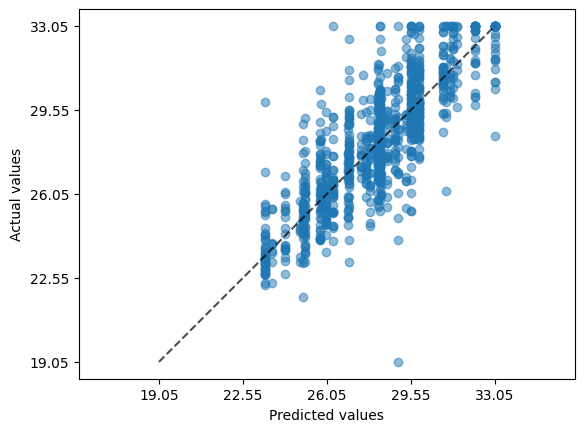

In [28]:
PredictionErrorDisplay.from_predictions(
  y_test,
  numeric_model.predict(X_test_preprocessed),
  kind="actual_vs_predicted",
  scatter_kwargs={"alpha": 0.5}
);

#### 7.4. Выводы 

R2 (коэффициент детерминации) в целом не плохой как для тренеровочной выборке так и валидационой

MSE (среднеквадратическая ошибка) в целом тоже не очень большая равна 2 что в целом можно считать что ошибка предсказания относительно никая.

### 10. Использование деревьев решений для задачи регрессии на числовых и категориальных данных

#### 10.1. Создание пайплайна для числовых и категориальных признаков

In [29]:
all_preprocessors = ColumnTransformer(transformers=[
  ('num_longitude', numeric_longitude_pipeline, numeric_longitude),
  ('num_latitude', numeric_latitude_pipeline, numeric_latitude),
  ('num_housing_median_age', numeric_housing_median_age_pipeline, numeric_housing_median_age),
  ('num_total_rooms', numeric_total_rooms_pipeline, numeric_total_rooms),
  ('num_total_bedrooms', numeric_total_bedrooms_pipeline, numeric_total_bedrooms),
  ('num_population', numeric_population_pipeline, numeric_population),
  ('num_households', numeric_households_pipeline, numeric_households),
  ('num_median_income', numeric_median_income_pipeline, numeric_median_income),
  ('cat_ocean_proximity', categorical_ocean_proximity_pipeline, categorical_ocean_proximity)
])

#### 9.2. Объединение названия числовых и категориальных колонок в один список

In [30]:
categorical_columns_list = np.hstack([
  numeric_longitude,
  numeric_latitude,
  numeric_housing_median_age,
  numeric_total_rooms,
  numeric_total_bedrooms,
  numeric_population,
  numeric_households,
  numeric_median_income,
  categorical_ocean_proximity
])

In [31]:
all_model = Pipeline([
  ('preprocessors', all_preprocessors),
  ('model', DecisionTreeRegressor(max_leaf_nodes=40,
    min_samples_split=5,
    criterion = 'absolute_error')
  )
])

In [32]:
all_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_longitude',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   None)]),
                                                  ['longitude']),
                                                 ('num_latitude',
                                                  Pipeline(steps=[('scaler',
                                                                   None)]),
                                                  ['latitude']),
                                                 ('num_housing_median_age',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('power',
                                                                   None...
                                                  Pipeline(steps=[('scaler',
                                                                   None)]),
                                                  ['households']),
                                                 ('num_median_income',
                                                  Pipeline(steps=[('scaler',
                                                                   None)]),
                                                  ['median_income']),
                                                 ('cat_ocean_proximity',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.001)),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  ['ocean_proximity'])])),
                ('model',
                 DecisionTreeRegressor(criterion='absolute_error',
                                       max_leaf_nodes=40,
                                       min_samples_split=5))])

In [33]:
all_model['preprocessors'].transformers_[8][1]['encoder'].target_mean

{'ocean_proximity': {'<1H OCEAN': 29.115303612821318,
  'INLAND': 26.073572082387283,
  'NEAR BAY': 29.31194266459132,
  'NEAR OCEAN': 29.094991490712573,
  'Other': 32.31331433937366}}

In [34]:
print(
  f'R2 на тренировочной выборке: {calculate_metric(all_model, X_train, y_train)}',
  f'R2 на валидационной выборке: {calculate_metric(all_model, X_test, y_test)}',
  f'MSE на тренировочной выборке: {calculate_metric(all_model, X_train, y_train, mse)}',
  f'MSE на валидационной выборке: {calculate_metric(all_model, X_test, y_test, mse)}',
  sep='\n'
)

R2 на тренировочной выборке: 0.710963830207629
R2 на валидационной выборке: 0.6941614395628252
MSE на тренировочной выборке: 1.8682698148964478
MSE на валидационной выборке: 2.004313929148187


In [35]:
cross_validation (
  X_train,
  y_train,
  all_model,
  scoring,
  ShuffleSplit(n_splits=5, random_state = 42)
)

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,3.571948,0.011001,0.689129,-1.937341,-1.031330,-7.840923
1,3.700202,0.012002,0.671194,-2.126168,-1.069175,-7.876685
2,3.578585,0.011001,0.699480,-1.948665,-1.041168,-6.691919
3,3.552121,0.013691,0.670372,-2.070304,-1.067587,-7.861323
4,3.718167,0.012001,0.687054,-2.002715,-1.053132,-8.773815




test_R2      0.683446
test_-MSE   -2.017039
test_-MAE   -1.052478
test_-Max   -7.808933
dtype: float64


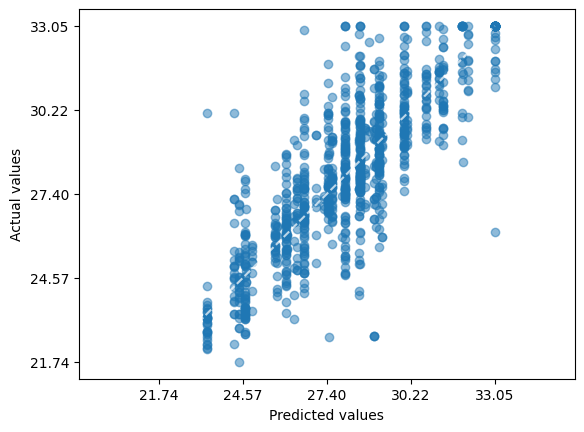

In [36]:
PredictionErrorDisplay.from_predictions(
  y_test,
  all_model.predict(X_test),
  kind="actual_vs_predicted",
  scatter_kwargs={"alpha": 0.5}, line_kwargs = {"color" : 'white'}
);

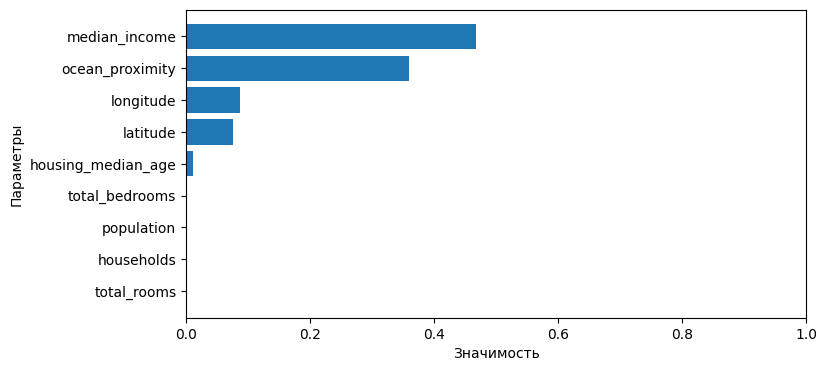

In [37]:
feature_importance_plotter(all_model['model'], categorical_columns_list)